In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
import seaborn as sns
from scipy import stats, special
import importlib.util
import os, re
import multiprocessing as mp
import Levenshtein as lv
import warnings
warnings.filterwarnings('ignore')

In [2]:
# functions
def load_data(fname):
    npzfile = np.load(fname)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2']
    Xv_test = npzfile['arr_3']
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    X_train = list()
    X_train.append(Xh_train)
    X_train.append(Xv_train[:,8:])
    X_test = list()
    X_test.append(Xh_test)
    X_test.append(Xv_test[:,8:])
    Y_train = Y_train.astype(np.float32).reshape((-1,1))
    Y_test = Y_test.astype(np.float32).reshape((-1,1))
    return X_train, X_test, Y_train, Y_test

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def is_odd(num):
    return num & 0x1

def makeNucSeq(input):
    # input is whole Xhot array
    bases = np.array(['N','A','C','G','T'])
    output = []
    for i in input:
        tmp = np.concatenate([np.zeros((i.shape[0],1)),i],axis=1).astype('bool')
        output.append(''.join(bases[np.argmax(tmp,axis = 1)]))
    return output

def seq_ratio(s1,s2,k):
    return lv.ratio(s1,s2)

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 

def reverse_complement(seq):    
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases

reverse_complement('ATGC')

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))

def zscore(x):
    x = np.transpose(x)
    #z = stats.zscores(x)
    z = (x-np.mean(x,axis=0))/np.std(x,axis=0)
    return np.transpose(z)

def gc_content(x):
    return np.mean([int(xx in ['G','C']) for xx in x])

def T_richness(x):
    '''T-richness in TSS to TATA region,
    ~150 bp from TTT in promoter'''
    return (x.apply(lambda x: x[limits[0][1]-150:limits[0][1]])
            .apply(lambda x: x.count('T')/len(x))
           )
def atg_5utr(x):
    '''check for premature ATG in 5UTR,
    count ATG exact mathces in 5utr sequence'''
    return (x.apply(lambda x: x[limits[1][0]:limits[1][1]])
            .apply(lambda x: x.count('ATG'))
           )

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
def get_dist_inner_loop(x):
    '''for distances'''
    s,x2,f_dist,k = x
    tmp = []
    for t in x2:
        if s=='' or t=='':
            tmp.append(np.nan)
        else:
            tmp.append(f_dist(s,t,k))
    return np.argmax(tmp)

def get_dist_k_parallel(x1,x2,f_dist,k,output='argman'):
    # parallelized version
    ncores = mp.cpu_count()
    dist = []
    with mp.Pool(processes=ncores) as p:
        args = [(s,x2,f_dist,k) for s in x1]
        dist.append(p.map(get_dist_inner_loop,args))
    return dist

def fix_float_list_comma(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]


In [3]:
# data params
folder = '../data/'
names = ['Promoter','5UTR','3UTR','Terminator']
limits = np.array([[0,400],[400,500],[500,750],[750,1000]])
label_names =["0_none", "1_low", "2_medium", "3_high"]
lmbda = 0.22
corrf = stats.spearmanr
n_samples = 64
cols_to_plot = ['isValid','isPadded','seqid','jacc','gc','y_pred_log',
                'len_5utr','len_3utr','gc_5utr','gc_3utr',
                'nucpos_depleted','core_pass','kozak_pass',
                'polyat_3utr_pass','posit_3utr_pass','effic_3utr_pass',
                't_richness','atg_5utr',
                'num_motifs', 'num_tfbs', 'num_rules', 
                'coverage_motifs','coverage_tfbs','coverage_rules', 
                ]
cols_to_bar = ['isValid','isPadded',
                'core_pass','kozak_pass','atg_5utr',
                'polyat_3utr_pass','posit_3utr_pass','effic_3utr_pass',
                ]
cols_to_box = ['seqid','jacc','y_pred_log','gc','nucpos_depleted',
                'len_5utr','len_3utr','gc_5utr','gc_3utr',
                't_richness',
                'num_motifs', 'num_tfbs', 'num_rules', 
                'coverage_motifs','coverage_tfbs','coverage_rules', 
                ]

## Generative experiments

(78, 12)
19


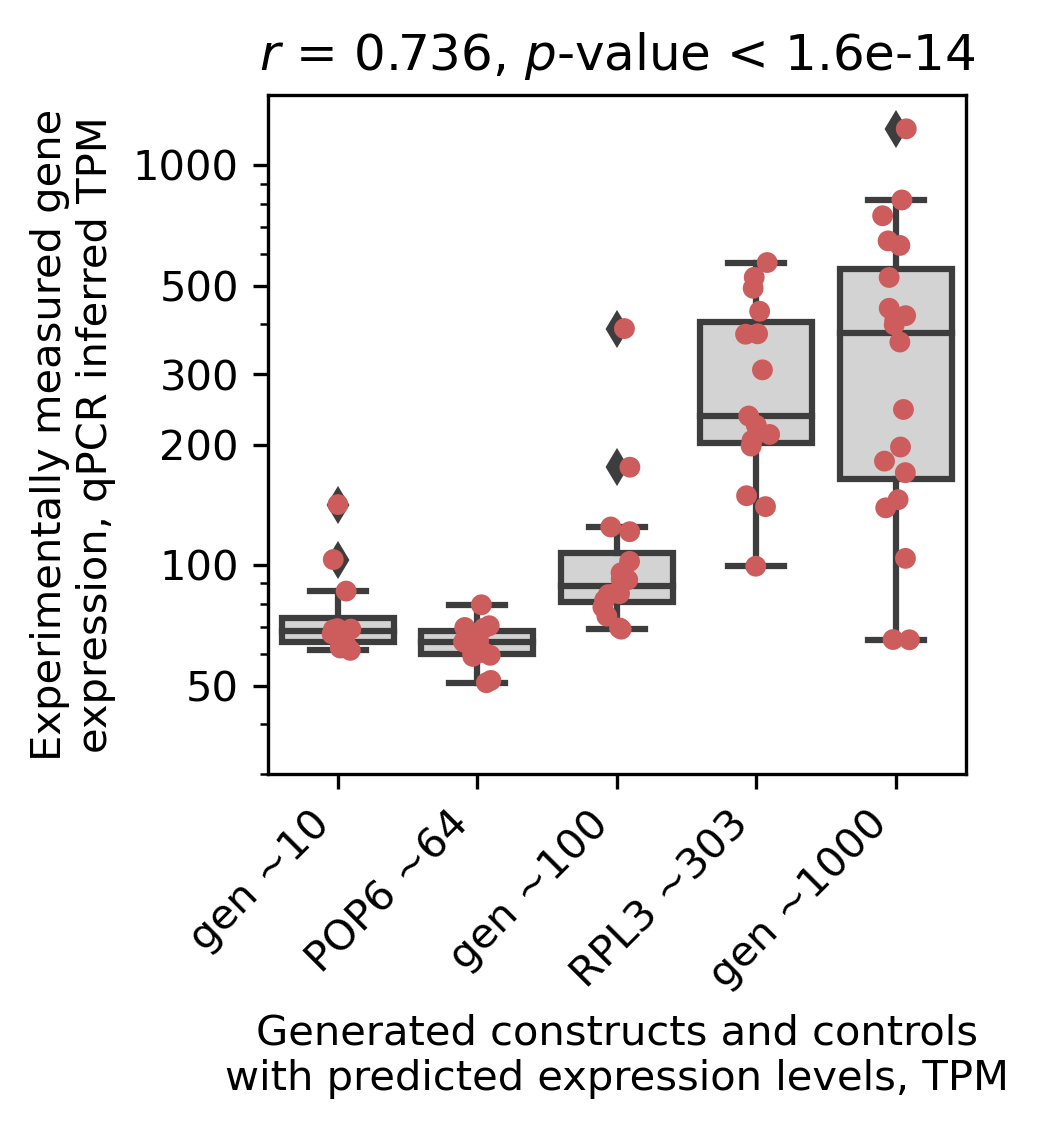

In [4]:
# experiment results

data = pd.read_csv(folder+'mrna_qpcr_batches_20210414_20210415_20210528.csv')
print(data.shape)
print(data.construct.nunique())
data.head()

# controls
addgenes = pd.DataFrame(['YGR030C','YOR063W'],columns=['name'])
addgenes['common_name'] = ['POP6','RPL3']
addgenes['ytpm_cr'] = [63.628151,303.201111] 
addgenes['ypred_cr'] = [6.788466,11.433858]
addgenes

# constructs predictions
df_sel = pd.read_csv(folder+'df_sel_exp_all_vals_sq91_fdr.tsv',sep='\t')
# add construct name
df_sel['name'] = (df_sel.name
                     .apply(lambda x: str(x) if x>9 else '0'+str(x))
                    )

# alltogether
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
di = {'POP6':'POP6 ~64',
      'RPL3':'RPL3 ~303',
      '1': 'gen ~10', 
      '2': 'gen ~100',
      '3': 'gen ~1000'}
order = ['gen ~10','POP6 ~64','gen ~100','RPL3 ~303','gen ~1000']
order

ax = sns.boxplot(data=data.replace({"correct_bin": di}),
           x='correct_bin',y='ytpm_cr',
           order=order
           )
for i,box in enumerate(ax.artists):
    box.set_facecolor('lightgrey')
    
sns.stripplot(data=data.replace({"correct_bin": di}),
           x='correct_bin',y='ytpm_cr',
           order=order,
           color = 'indianred',
           size=5
           )
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=45,ha='right')
plt.yticks([50,100,200,300,500,1000],[50,100,200,300,500,1000])
plt.xlabel('Generated constructs and controls\nwith predicted expression levels, TPM')
plt.ylabel('Experimentally measured gene\nexpression, qPCR inferred TPM')
plt.ylim([30,1500])

data2 = (data.replace({"correct_bin": di})
         .query('correct_bin.isin(@order)')
         .merge(df_sel[['name','ypred_cr','ytpm_cr',]]
                 .append(addgenes[['common_name','ytpm_cr','ypred_cr']]
                 .rename(columns={'common_name':'name'}),
                 ignore_index=True)
,left_on='construct',right_on='name',how='left')
)

y = data2.dropna(subset=['ytpm_cr_y']).ytpm_cr_x.values
x = data2.dropna(subset=['ytpm_cr_y']).ytpm_cr_y.values
plt.title('$r$ = '+str("%.3f" % corrf(x,y)[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(corrf(x,y)[1])))

plt.show()


In [5]:
# reported values

tmp = data.groupby('correct_bin').ytpm_cr.mean().iloc[:3]
print(tmp)     
# fold diff
print(tmp.divide([10,100,1000]))
# perc diff
print(tmp.subtract([10,100,1000]).abs().divide([10,100,1000]))
# weighted average perc diff overall
print(tmp.subtract([10,100,1000]).abs()
      .divide([10,100,1000])
      .multiply(data.groupby('correct_bin').ytpm_cr.count().iloc[:3])
      .mean()
     )
# fold diff for high bin
print(1/0.397186)

# how many in high group surpass average RPL3 level
tmp = data.query('correct_bin=="3"').groupby('construct').ytpm_cr.mean().reset_index()
print(tmp[tmp.ytpm_cr>data.groupby('correct_bin').ytpm_cr.mean().iloc[4]])

# out of how many
print(data.groupby(['correct_bin']).construct.nunique())
print(4/7)

# by how much
print(tmp[tmp.ytpm_cr>data.groupby('correct_bin').ytpm_cr.mean().iloc[4]]
 .ytpm_cr
 .divide(data.groupby('correct_bin').ytpm_cr.mean().iloc[4])
)

correct_bin
1     77.112906
2    113.891528
3    397.186466
Name: ytpm_cr, dtype: float64
correct_bin
1    7.711291
2    1.138915
3    0.397186
dtype: float64
correct_bin
1    6.711291
2    0.138915
3    0.602814
dtype: float64
31.604800694640915
2.517712104656257
  construct     ytpm_cr
3        29  558.616070
4        31  806.449499
5        33  567.972766
6        34  358.568353
correct_bin
1       4
2       6
3       7
POP6    1
RPL3    1
Name: construct, dtype: int64
0.5714285714285714
3    1.842393
4    2.659782
5    1.873253
6    1.182608
Name: ytpm_cr, dtype: float64


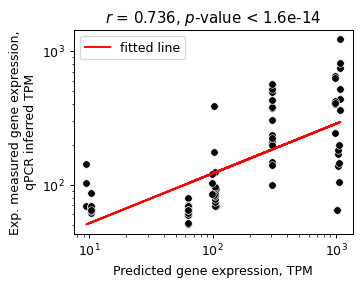

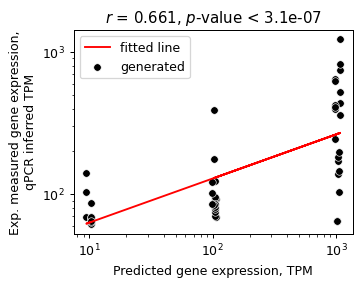

In [6]:
# correlations s figs

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))

y = data2.ytpm_cr_x.values
x = data2.ytpm_cr_y.values
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=data2.query('~construct.isin(["RPL3","POP6"])'),
               x='ytpm_cr_y',y='ytpm_cr_x',
               color='k') 
sns.scatterplot(data=data2.query('construct.isin(["RPL3"])'),
               x='ytpm_cr_y',y='ytpm_cr_x',
               color='k')
sns.scatterplot(data=data2.query('construct.isin(["POP6"])'),
               x='ytpm_cr_y',y='ytpm_cr_x',
               color='k')

plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted gene expression, TPM')
plt.ylabel('Exp. measured gene expression,\nqPCR inferred TPM')
plt.title('$r$ = '+str("%.3f" % corrf(x,y)[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(corrf(x,y)[1])))
plt.show()

plt.figure(figsize=(4,3))
order = ['gen ~10','gen ~100','gen ~1000']

y = data2.query('~construct.isin(["RPL3","POP6"])').ytpm_cr_x.values
x = data2.query('~construct.isin(["RPL3","POP6"])').ytpm_cr_y.values
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=data2.query('~construct.isin(["RPL3","POP6"])'),
               x='ytpm_cr_y',y='ytpm_cr_x',
               color='k',label='generated')

plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted gene expression, TPM')
plt.ylabel('Exp. measured gene expression,\nqPCR inferred TPM')
plt.title('$r$ = '+str("%.3f" % corrf(x,y)[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(corrf(x,y)[1])))
plt.show()


In [7]:
# s table
(data2.groupby(['construct','correct_bin','batch','ytpm_cr_y','2pddct_avg'])
 ['ytpm_cr_x']
 .mean()
 .reset_index()
 .sort_values(by=['construct','correct_bin'])
)

,construct,correct_bin,batch,ytpm_cr_y,2pddct_avg,ytpm_cr_x
0,05,gen ~10,5,10.328059,12.653263,63.116089
1,06,gen ~10,5,10.406671,28.354659,66.466713
2,07,gen ~10,5,10.351310,64.666278,74.215490
3,10,gen ~10,4,9.454668,13.949723,104.653331
4,15,gen ~100,2,104.038360,51.685853,83.333326
5,17,gen ~100,4,97.943510,13.640540,102.898475
6,18,gen ~100,2,103.646286,36.742456,74.232931
7,19,gen ~100,2,103.860170,85.743750,104.074279
8,20,gen ~100,2,106.478520,47.349960,80.692806
9,23,gen ~100,4,103.328480,33.720039,216.865043


(425, 38)


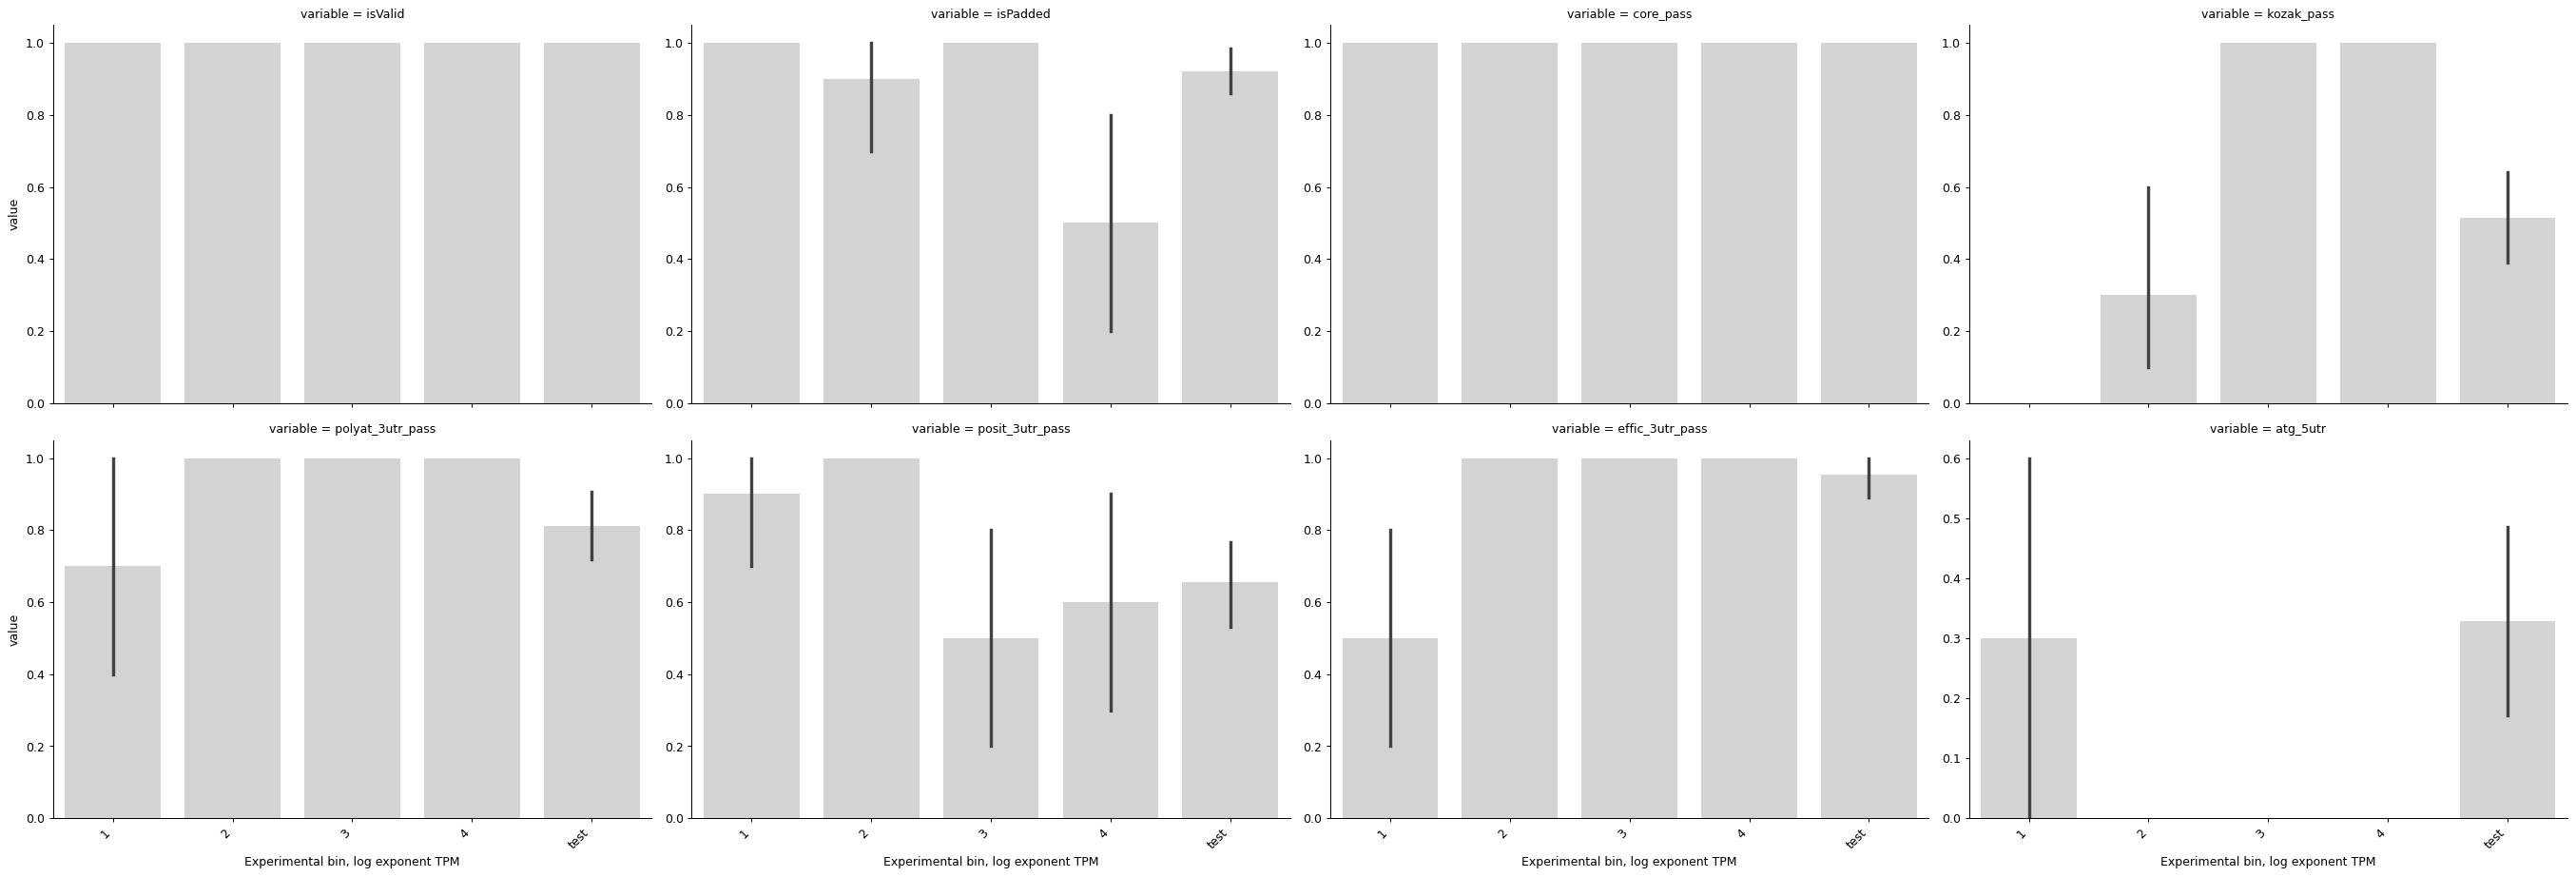

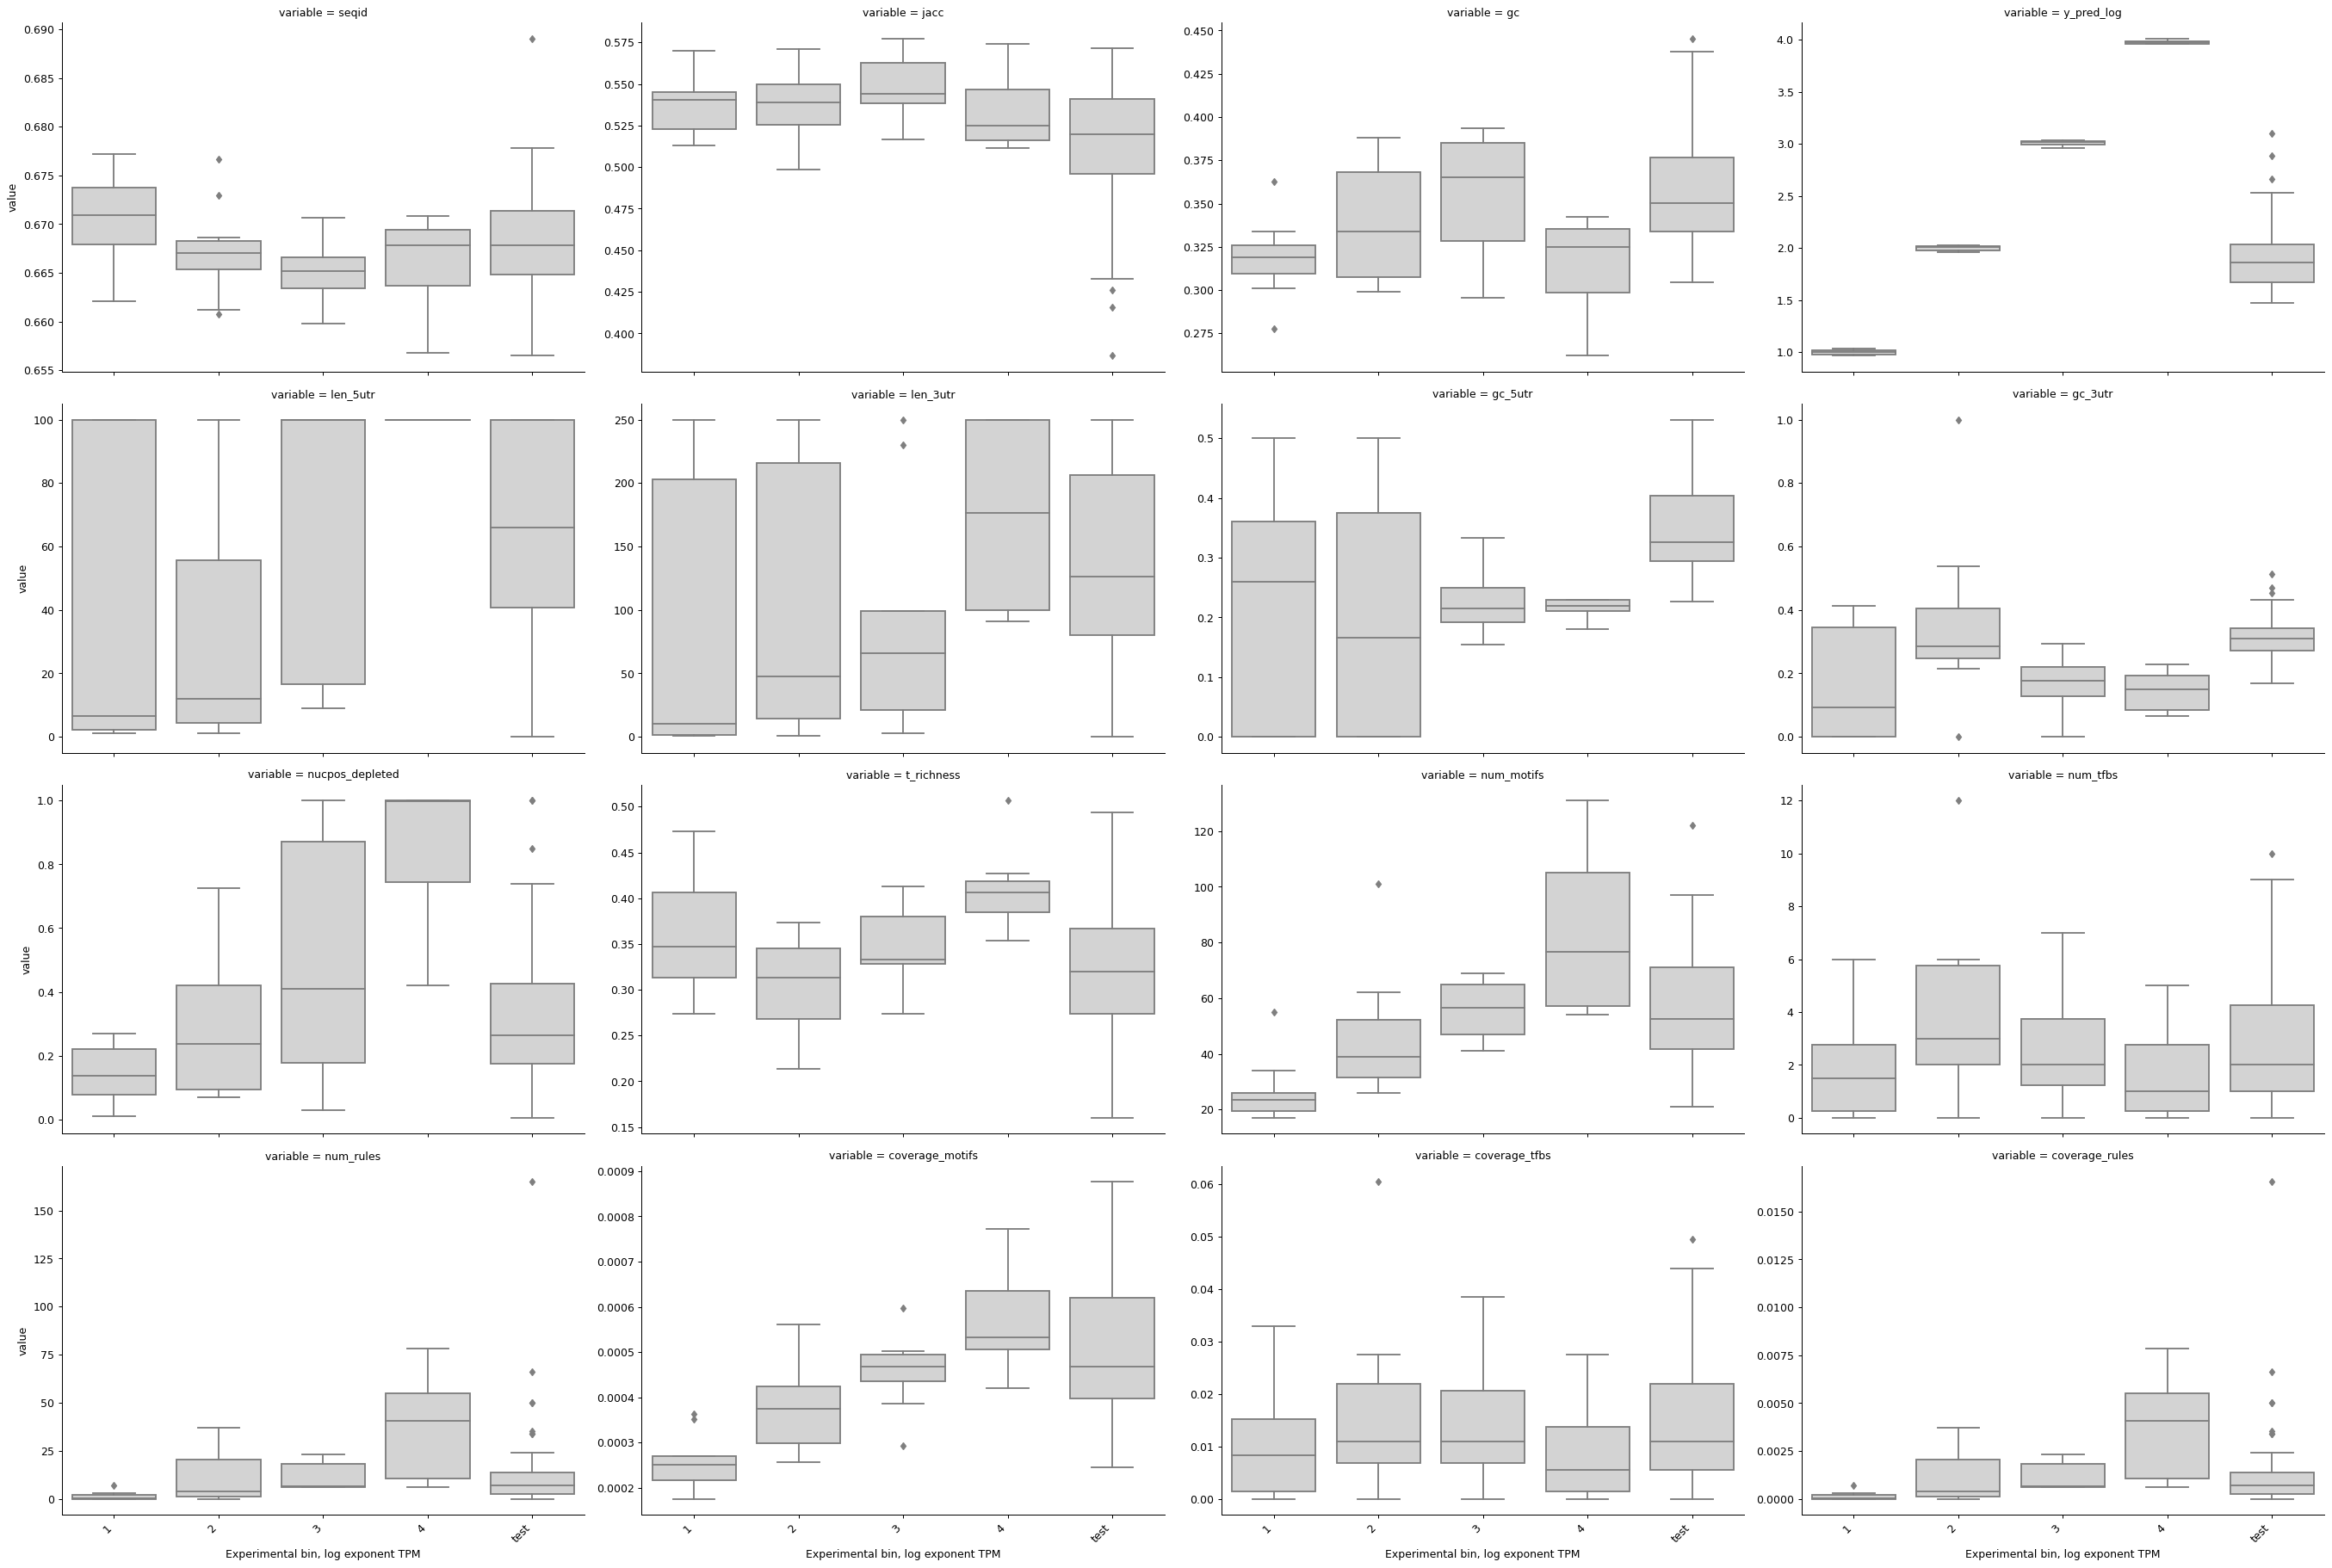

In [8]:
# plot sequence properties

# load test data
df_test = (pd.read_csv(folder+'Test_set_gan_metrics_df_sq91_fdr.tsv',sep='\t')
             .drop(columns=['num_motifs','num_tfbs'])
             .rename(columns={'num_seq_id':'num_motifs',
                            'num_tfbs_all':'num_tfbs',
                             })
          )
df_test['iter'] = 'test'
print(df_test.shape)

# add metrics    
df_test['gc_5utr'] = (df_test.seq
                          .apply(lambda x: x[limits[1][0]:limits[1][1]].replace('N',''))
                          .apply(gc_content)
                         )
df_test['gc_3utr'] = (df_test.seq
                          .apply(lambda x: x[limits[2][0]:limits[2][1]].replace('N',''))
                          .apply(gc_content)
                         )
df_test['t_richness'] = T_richness(df_test.seq)
df_test['atg_5utr'] =  atg_5utr(df_test.seq)

# log tpm
df_test['y_pred_log'] = df_test.y_pred.apply(lambda x: np.log10(boxtpm(x,lmbda)))
df_sel['y_pred_log'] = df_sel.ypred_cr.apply(lambda x: np.log10(boxtpm(x,lmbda)))

# plot
df_plot = (df_sel
            .rename(columns={'num_seq_id':'num_motifs',
                             'num_tfbs_all':'num_tfbs',
                             't_richness_150':'t_richness'
                 })
           .append(df_test.rename(columns={'iter':'correct_bin'})
                   .sample(n=n_samples,random_state=322))
           .melt(id_vars=['correct_bin','seq'], value_vars=cols_to_plot)
          )

g = sns.catplot(data=df_plot.query('variable.isin(@cols_to_bar)'),
                color='lightgrey',
            x='correct_bin',y='value',
            col='variable',col_wrap=4,
            kind='bar',sharey=False,
            aspect=1.5)
[ax.set_xlabel('Experimental bin, log exponent TPM') for ax in g.axes.flat[-4:]]
[plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
plt.show()

g = sns.catplot(data=df_plot.query('variable.isin(@cols_to_box)'),
              color='lightgrey',
            x='correct_bin',y='value',
            col='variable',col_wrap=4,
            kind='box',sharey=False,
            aspect=1.5)
[ax.set_xlabel('Experimental bin, log exponent TPM') for ax in g.axes.flat[-4:]]
[plt.setp(ax.get_xticklabels(), rotation=45, ha='right') for ax in g.axes.flat]
plt.show()

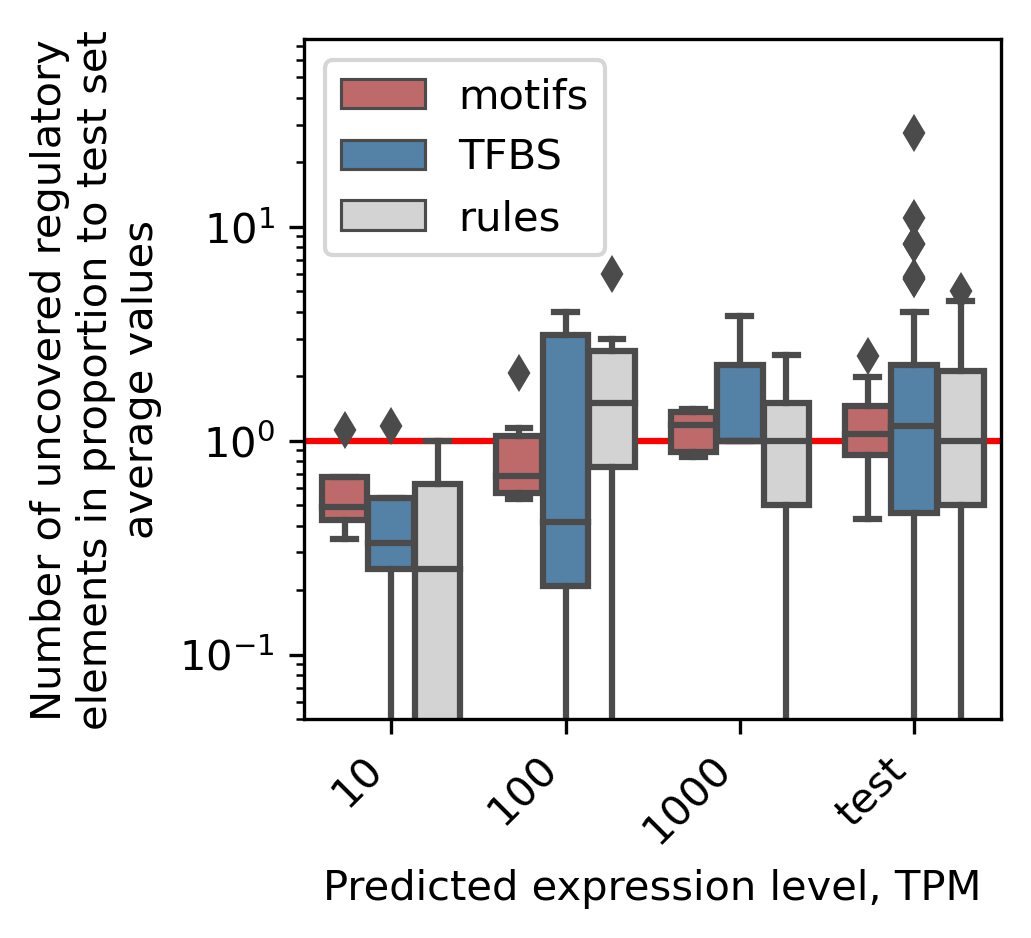

In [9]:
# Plot properties of tested sequences

tmp = data.construct.unique()
          
# plot
df_plot = (df_sel.query('name.isin(@tmp)')
            .rename(columns={'num_seq_id':'num_motifs',
                             'num_tfbs_all':'num_tfbs',
                             't_richness_150':'t_richness'
                 })
           .append(df_test.rename(columns={'iter':'correct_bin'})
                   .sample(n=n_samples,random_state=322))
           .melt(id_vars=['correct_bin','seq'], value_vars=cols_to_plot)
          )

di={"num_motifs":'motifs',"num_tfbs":'TFBS',"num_rules":'rules'}
di.keys()
df_test[list(di.keys())].median()

df_plot['value'] = df_plot.value.astype(float)

df_plot2 = df_plot.query('variable.isin(@di.keys())')

df_plot2['avg_value'] = (df_plot
                         .query('variable.isin(@di.keys())')
                         .set_index('variable')
                         .value
                         .divide(df_test[list(di.keys())].median())
                         .values
                        )

df_test[list(di.keys())].describe()

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data=df_plot2
            .replace({'variable':di}),
                hue='variable',
            x='correct_bin',y='avg_value',
           palette=['indianred','steelblue','lightgrey'])
plt.plot([-1,10],[1,1],'r',zorder=0)
plt.yscale('log')
plt.legend(title='',loc='upper left') 
plt.xlim(-0.5,3.5)
plt.ylim(0.5e-1,75)
plt.ylabel('Number of uncovered regulatory\nelements in proportion to test set\naverage values')
plt.xticks([0,1,2,3],['10','100','1000','test'],
          rotation=45,ha='right')
plt.xlabel('Predicted expression level, TPM')
plt.show()

(17, 67)
24
(64, 43)
81
0.6690017513134852


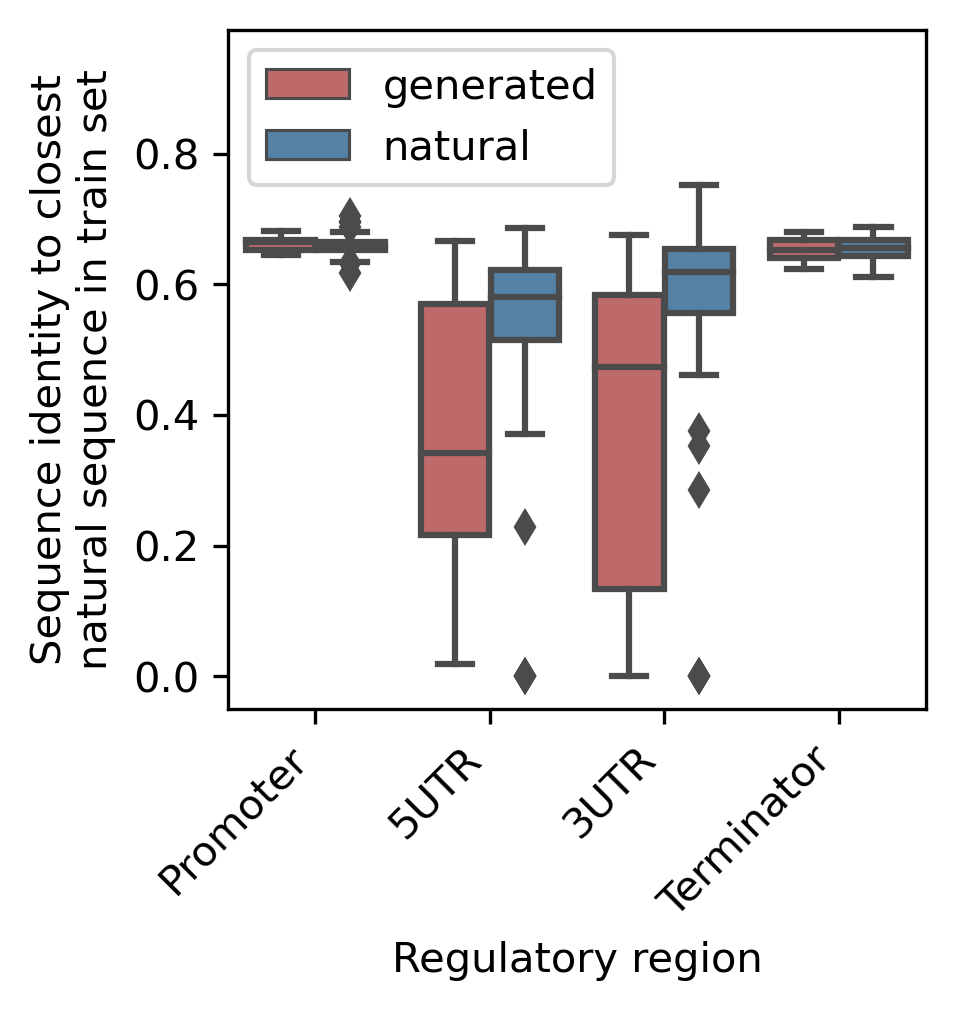

In [10]:
# seq. id. to closest natural

# load data
X_train, X_test, Y_train, Y_test = load_data(folder+'scerevisiae.rsd1.lmbda_22.1000.npz')
Y = np.concatenate((Y_train, Y_test))
X = np.concatenate((X_train[0], X_test[0]))

# fix values after loading
df_sel['seqid_closest_train'] = df_sel.seqid_closest_train.apply(fix_float_list_comma)

tmp = data.construct.unique()
df_exp = (df_sel.query('name.isin(@tmp)')
          .rename(columns={'num_seq_id':'num_motifs',
                        'num_tfbs_all':'num_tfbs',
                           't_richness_150':'t_richness'
                           })
         )
print(df_exp.shape)

# all cols to plot inside
print(len(cols_to_plot))
df_exp.columns[df_exp.columns.isin(cols_to_plot)].shape
df_exp['y_pred_log'] = df_exp.y_pred.apply(lambda x: np.log10(boxtpm(x,lmbda)))

df_test_smpl = df_test.sample(n=n_samples,random_state=322)
print(df_test_smpl.shape)

# seqids
# save closest natural seqs to df
Xtr = makeNucSeq(X_train[0])
strain = [x.replace('N','') for x in Xtr]
seq_acgt = [x.replace('N','') for x in df_test_smpl.seq]

idx = get_dist_k_parallel(seq_acgt,strain,seq_ratio,k=5)
df_test_smpl['seq_closest_train'] = [Xtr[idxi] for idxi in idx[0]]

# get region seq ids
tmp = []
for idx,row in df_test_smpl.iterrows():
    tmp_seqid = []
    for lim in limits:
        tmp_seqid.append(seq_ratio(row.seq[lim[0]:lim[1]].replace('N',''),
                           row.seq_closest_train[lim[0]:lim[1]].replace('N',''),
                           k=5))
    tmp.append(tmp_seqid)
    
df_test_smpl['seqid_closest_train'] = tmp

# plot catplot
df_test_smpl['correct_bin'] = 'natural'
df_test_smpl['type'] = 'natural'
df_exp['type'] = 'generated'
tmp = (df_exp[['correct_bin','seqid_closest_train','type']]
       .append(df_test_smpl[['correct_bin','seqid_closest_train','type']])
      )
print(tmp.shape[0])

df_plot = (pd.DataFrame(tmp.seqid_closest_train.tolist(),columns=names)
         .unstack()
         .reset_index()
         .merge(tmp.reset_index()[['correct_bin','type']],
                left_on='level_1',right_index=True,how='left')
        )

# across regions
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))

# compute distances each test seq. to closest train to get median diff
avg = df_test.seqid.median()
print(avg)

sns.boxplot(data=df_plot,x='level_0',y=0,
            hue='type', #color='lightgrey',
            palette=['indianred','steelblue']
           )
plt.ylabel('Sequence identity to closest\nnatural sequence in train set')
plt.xlabel('Regulatory region')
plt.xticks(rotation=45,ha='right')
plt.legend(loc=2)
plt.ylim([-0.05,0.99])
plt.show()


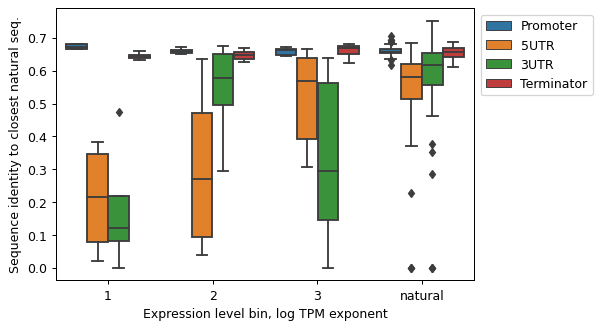

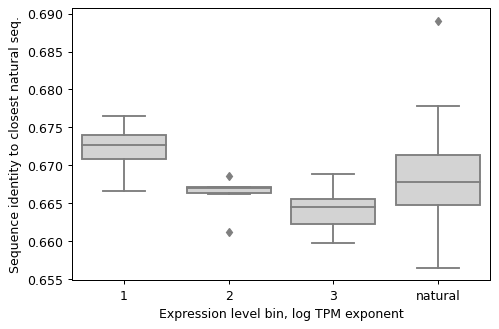

In [11]:
# supplementary
mpl.rcParams['figure.dpi'] = 90
sns.boxplot(data=df_plot,x='correct_bin',
           y=0,hue='level_0')
plt.ylabel('Sequence identity to closest natural seq.')
plt.xlabel('Expression level bin, log TPM exponent')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#just overall
df_exp['seqid'] = df_exp.seqid_closest_train_whole
sns.boxplot(data=df_exp.append(df_test_smpl),
           x='correct_bin',y='seqid',
           color='lightgrey')
plt.ylabel('Sequence identity to closest natural seq.')
plt.xlabel('Expression level bin, log TPM exponent')
plt.show()


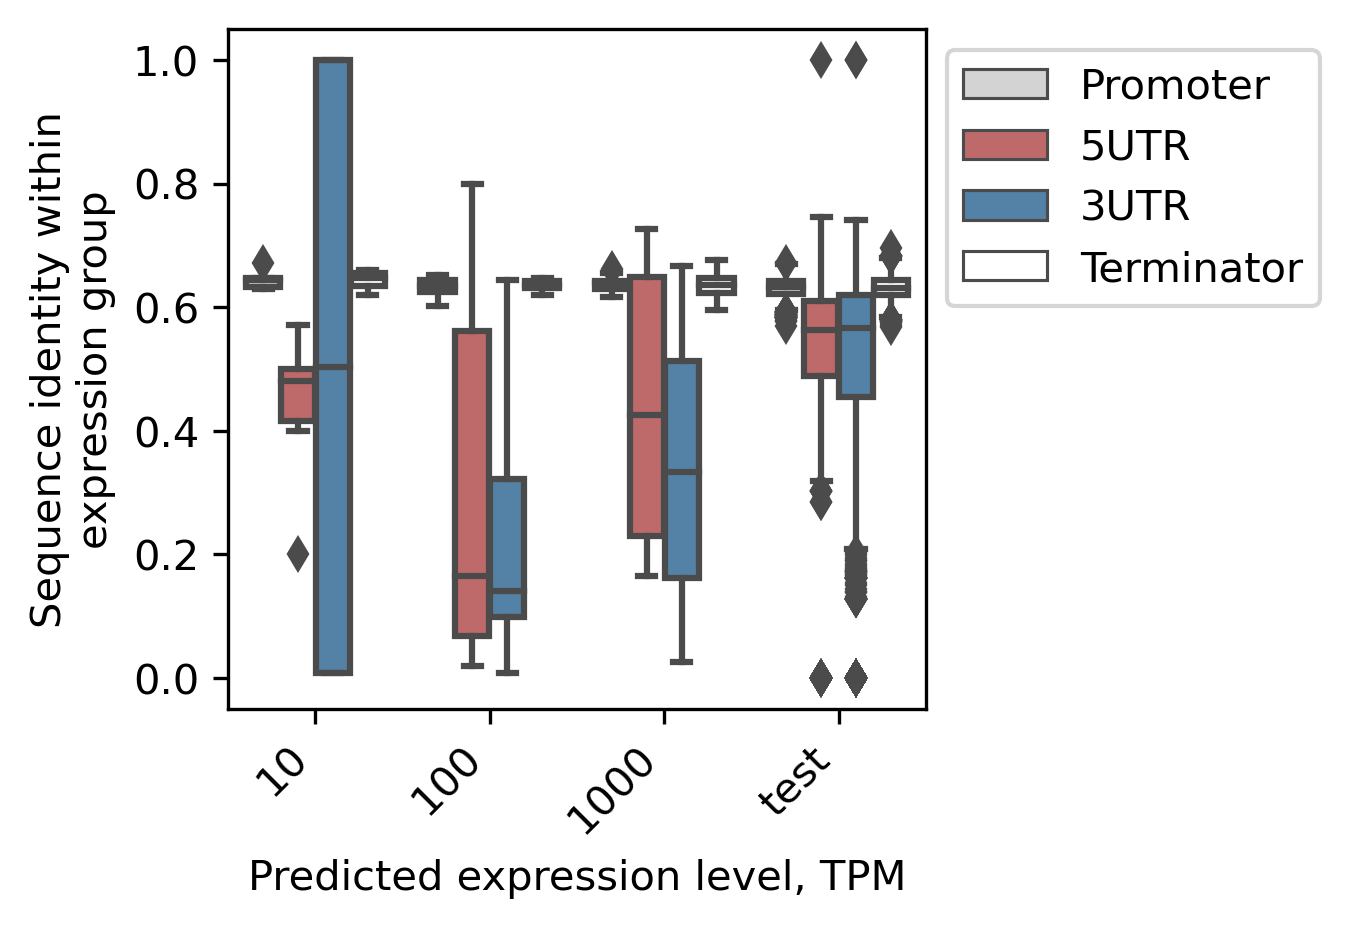

In [12]:
# seqid within groups, add test group
df_bin = (df_exp[['correct_bin','seq','type']]
       .append(df_test_smpl[['correct_bin','seq','type']])
      )

tmp = []
for lim in limits:
    tmp_seqid = []
    for i in range(df_bin.shape[0]):
        for j in range(df_bin.shape[0]):
            tmp_seqid.append([i,j,seq_ratio(df_bin.iloc[i].seq[lim[0]:lim[1]].replace('N',''),
                           df_bin.iloc[j].seq[lim[0]:lim[1]].replace('N',''),
                           k=5)])
    tmp_seqid = (pd
                 .DataFrame(tmp_seqid,columns=['s1','s2','seqid'])
                 .set_index(['s1','s2'])
                 .unstack()
                )
    tmp.append(tmp_seqid)
    
# per exp bin stack all upper of df values
df_plot = []

k = 0
for df in tmp:

    # replace with exp bins
    df_tmp = df.copy(deep=True)
    df_tmp.columns = df_bin.correct_bin.values
    df_tmp.index = df_bin.correct_bin.values
    for binn in df_bin.correct_bin.unique():
        
        # take upper and stack
        df_plot.append(pd.DataFrame(df_tmp.loc[binn,binn]
         .where(np.triu(np.ones(df_tmp.loc[binn,binn].shape),k=1)
                .astype(np.bool))
         .stack()
         .reset_index(drop=True)
        ))
        df_plot[-1]['exp_bin'] = binn
        df_plot[-1]['region'] = names[k]
    k+=1
    
df_plot = pd.concat(df_plot)
df_plot

# same plots as above gen to train
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data=df_plot,
            x='exp_bin',
           y=0,hue='region',
           palette=['lightgrey','indianred','steelblue','white']
           )
plt.ylabel('Sequence identity within\nexpression group')
plt.xticks([0,1,2,3],['10','100','1000','test'],
          rotation=45,ha='right')
plt.xlabel('Predicted expression level, TPM')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
            

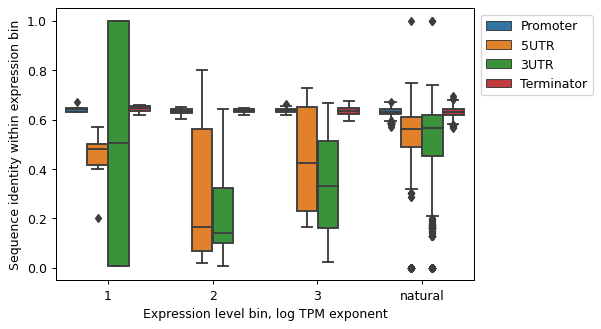

In [13]:
# seqid within groups, add test group
df_bin = (df_exp[['correct_bin','seq','type']]
       .append(df_test_smpl[['correct_bin','seq','type']])
      )

tmp = []
for lim in limits:
    tmp_seqid = []
    for i in range(df_bin.shape[0]):
        for j in range(df_bin.shape[0]):
            tmp_seqid.append([i,j,seq_ratio(df_bin.iloc[i].seq[lim[0]:lim[1]].replace('N',''),
                           df_bin.iloc[j].seq[lim[0]:lim[1]].replace('N',''),
                           k=5)])
    tmp_seqid = (pd
                 .DataFrame(tmp_seqid,columns=['s1','s2','seqid'])
                 .set_index(['s1','s2'])
                 .unstack()
                )
    tmp.append(tmp_seqid)
    
# per exp bin stack all upper of df values
df_plot = []

k = 0
for df in tmp:

    # replace with exp bins
    df_tmp = df.copy(deep=True)
    df_tmp.columns = df_bin.correct_bin.values
    df_tmp.index = df_bin.correct_bin.values
    for binn in df_bin.correct_bin.unique():

        # take upper and stack
        df_plot.append(pd.DataFrame(df_tmp.loc[binn,binn]
         .where(np.triu(np.ones(df_tmp.loc[binn,binn].shape),k=1)
                .astype(np.bool))
         .stack()
         .reset_index(drop=True)
        ))
        df_plot[-1]['exp_bin'] = binn
        df_plot[-1]['region'] = names[k]
    k+=1
    
df_plot = pd.concat(df_plot)
df_plot

# same plots as above gen to train
mpl.rcParams['figure.dpi'] = 90
sns.boxplot(data=df_plot,
            x='exp_bin',
           y=0,hue='region',
           )

plt.ylabel('Sequence identity within expression bin')
plt.xlabel('Expression level bin, log TPM exponent')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
            

(2058, 2)


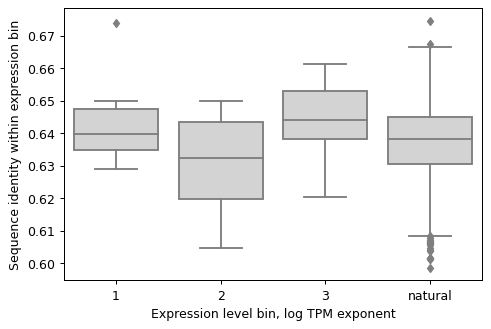

In [14]:
# seqid within groups, add test group
df_bin = (df_exp[['correct_bin','seq','type']]
       .append(df_test_smpl[['correct_bin','seq','type']])
      )

tmp_seqid = []
for i in range(df_bin.shape[0]):
    for j in range(df_bin.shape[0]):
        tmp_seqid.append([i,j,seq_ratio(df_bin.iloc[i].seq.replace('N',''),
                       df_bin.iloc[j].seq.replace('N',''),
                       k=5)])
tmp_seqid = (pd
             .DataFrame(tmp_seqid,columns=['s1','s2','seqid'])
             .set_index(['s1','s2'])
             .unstack()
            )
tmp_seqid
    
# per exp bin stack all upper of df values
df_plot = []

k = 0
df_tmp = tmp_seqid.copy(deep=True)
df_tmp.columns = df_bin.correct_bin.values
df_tmp.index = df_bin.correct_bin.values
for binn in df_bin.correct_bin.unique():

    # take upper and stack
    df_plot.append(pd.DataFrame(df_tmp.loc[binn,binn]
     .where(np.triu(np.ones(df_tmp.loc[binn,binn].shape),k=1)
            .astype(np.bool))
     .stack()
     .reset_index(drop=True)

    ))
    df_plot[-1]['exp_bin'] = binn
    
df_plot = pd.concat(df_plot)
print(df_plot.shape)

# same plots as above gen to train
mpl.rcParams['figure.dpi'] = 90
sns.boxplot(data=df_plot,
            x='exp_bin',y=0,color='lightgrey')
plt.ylabel('Sequence identity within expression bin')
plt.xlabel('Expression level bin, log TPM exponent')
plt.show()
            

(48, 36)


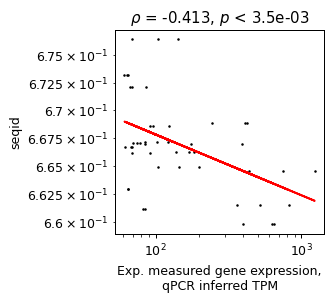

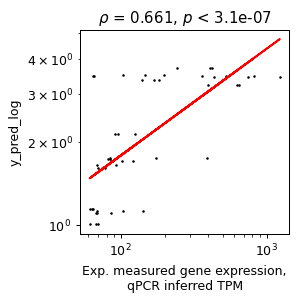

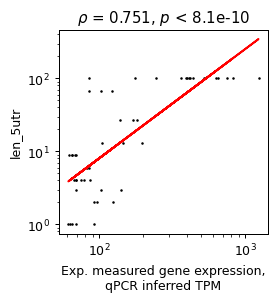

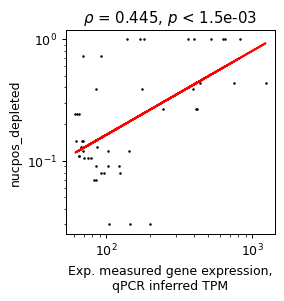

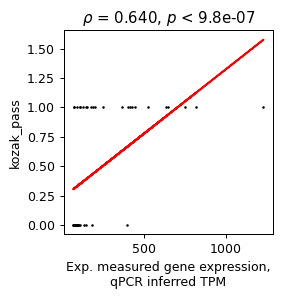

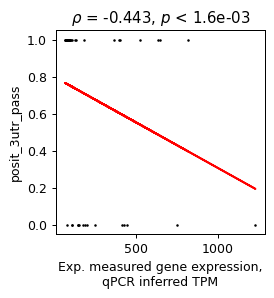

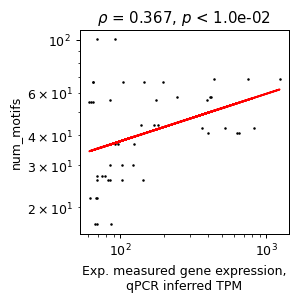

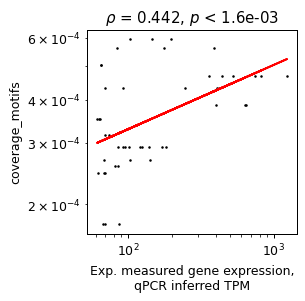

In [15]:
# correlations

mpl.rcParams['figure.dpi'] = 90

# merge qpcr results
cols = cols_to_plot.copy()
cols.extend(['name'])
df_corr = (data
           .drop(columns='name')
           .merge(df_exp
                     .append(df_test.rename(columns={'iter':'correct_bin'})
                     .sample(n=n_samples,random_state=322))
                     [cols],
                    left_on='construct',right_on='name',
                    how='left')
          .dropna()
          )
print(df_corr.shape)

k=1
tmp = []
col1 = 'ytpm_cr'
for col2 in cols[:-1]: 
    x = df_corr[col1].values
    y = df_corr[col2].values
    
    r,p = corrf(x,y)
    
    if p < 0.05:
        plt.figure(figsize=(3,3))

        slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
        plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')

        if 'pass' in col2:
            plt.plot(x, slope*x+intercept, 'r', label='fitted line')
        else:
            plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
            plt.xscale('log')
            plt.yscale('log')

        plt.xlabel('Exp. measured gene expression,\nqPCR inferred TPM')
        plt.ylabel(col2)
        plt.title(r'$\rho$ = '+str("%.3f" % r)+
                ', $p$ < '+str("%.1e" % fix_pvals(p)))

        tmp.append([col2,corrf(x,y)[0],fix_pvals(p)])
        plt.show()

    k+=1


## Mutagenesis experiments

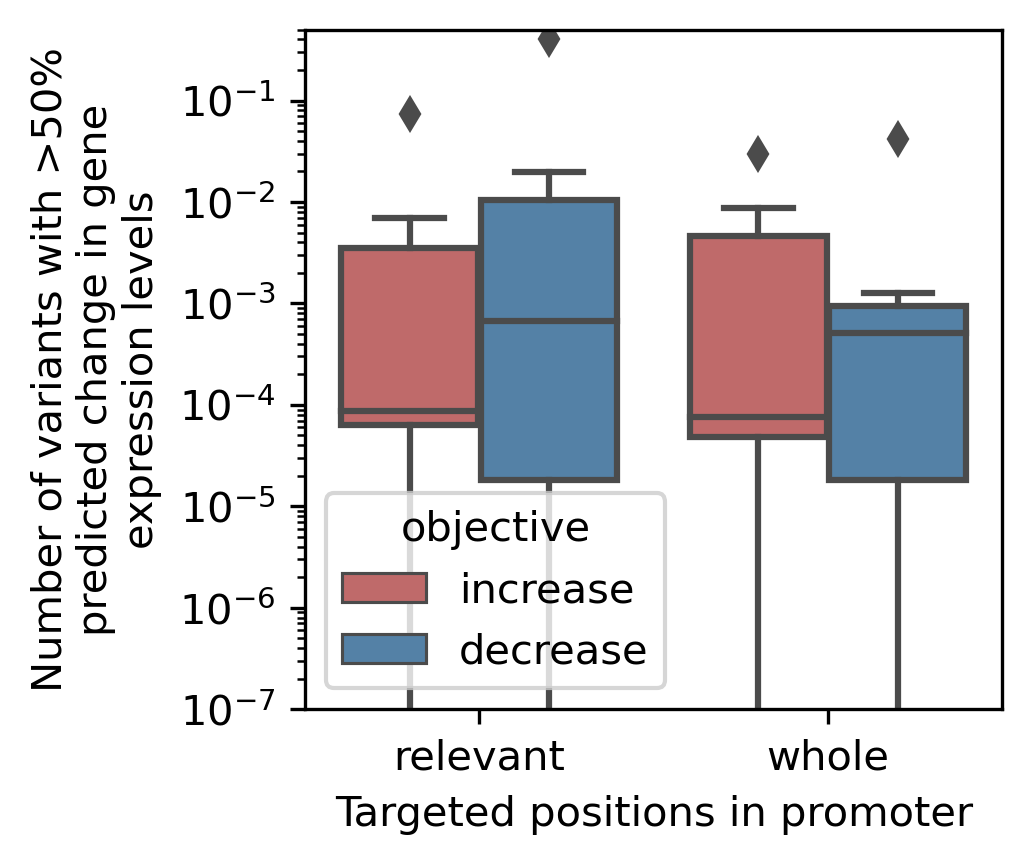

region    win_cut        perc
relevant  win=10;cut=1   1.0     0.000000
                         2.0     0.000000
                         5.0     0.000012
                         10.0    0.000377
whole     win=400;cut=0  1.0     0.000000
                         2.0     0.000000
                         5.0     0.000003
                         10.0    0.000297
dtype: float64


In [16]:
# mutagenesis stats
df_stat = pd.read_csv(folder+'df_mut_stats.csv')
df_stat['perc'] = df_stat.perc*100

# 10%
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data=df_stat
                .query('win_cut.isin(["win=400;cut=0","win=10;cut=1"])')
                .query('perc==10')
                .melt(id_vars=['region'],value_vars=['increase','decrease'])
                .rename(columns={'variable':'objective'}),
            x='region',y='value',
            hue='objective', #estimator=np.median,
           palette=['indianred','steelblue'])
plt.yscale('log')
plt.ylim(1e-7,5e-1)
plt.xlabel('Targeted positions in promoter')
plt.ylabel('Number of variants with >50%\npredicted change in gene\nexpression levels')
plt.show()

# reported values
print(df_stat
 .query('win_cut.isin(["win=400;cut=0","win=10;cut=1"])')
 .groupby(['region','win_cut','perc'])[['increase','decrease']].median().mean(axis=1)
)


In [17]:
# s table
(df_stat
 .groupby(['region','win_cut','perc'])[['increase','decrease']]
 .median()
)

increase  decrease
region   win_cut       perc                    
relevant win=10;cut=1  1.0   0.000000  0.000000
                       2.0   0.000000  0.000000
                       5.0   0.000013  0.000010
                       10.0  0.000087  0.000667
         win=10;cut=2  1.0   0.000000  0.000000
                       2.0   0.000000  0.000000
                       5.0   0.000010  0.000003
                       10.0  0.000097  0.000107
         win=1;cut=1   1.0   0.000000  0.000000
                       2.0   0.000000  0.000000
                       5.0   0.000040  0.000037
                       10.0  0.000090  0.001580
         win=1;cut=2   1.0   0.000000  0.000000
                       2.0   0.000000  0.000000
                       5.0   0.000000  0.000020
                       10.0  0.000000  0.000027
whole    win=400;cut=0 1.0   0.000000  0.000000
                       2.0   0.000000  0.000000
                       5.0   0.000007  0.000000
                       10.0  0.000077  0.000517

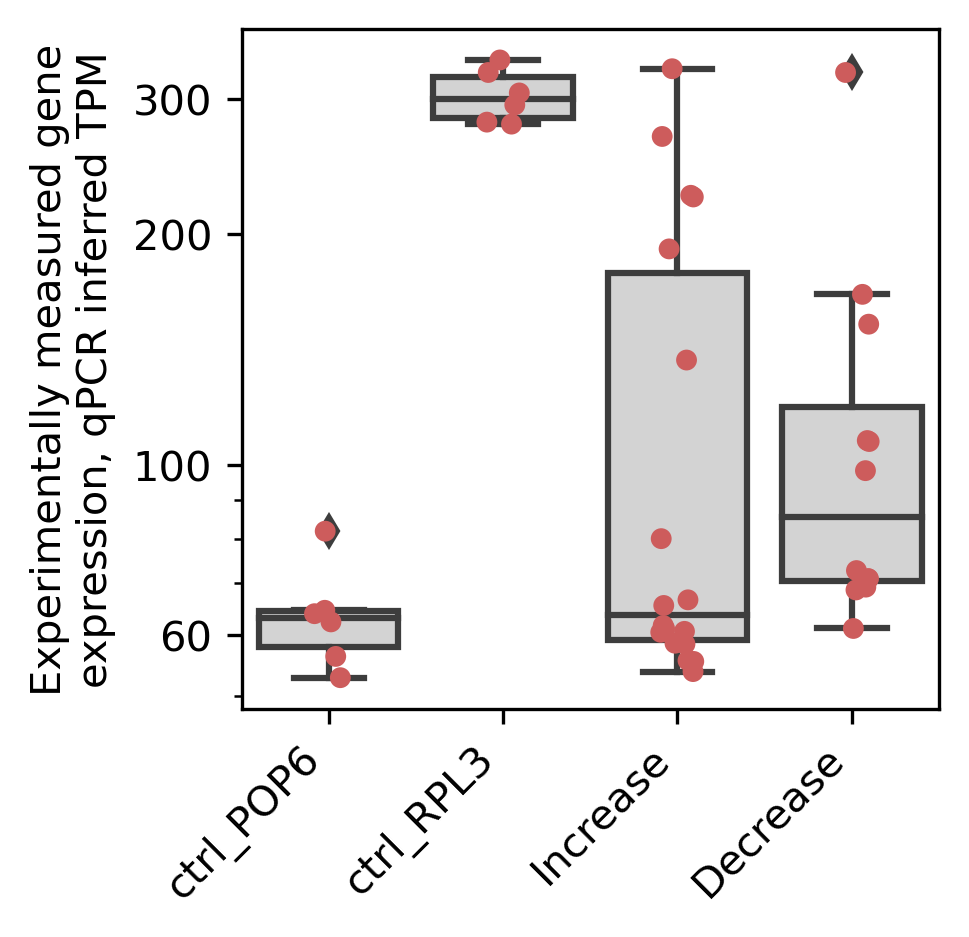

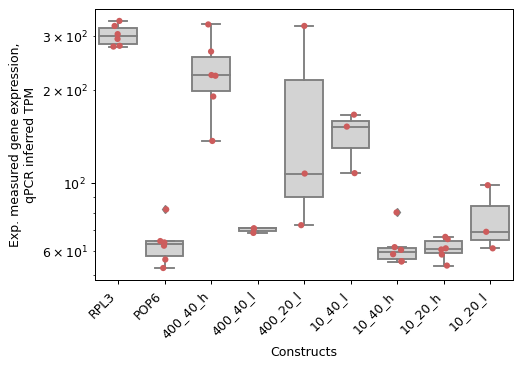

In [18]:
# mutagenesis experiments
data = (pd
        .read_csv(folder+'mrna_qpcr_exp_direct_mutation_2021_5_28.csv')
        .drop(columns=['Unnamed: 0','index'])
       )
df_exp2 = pd.read_csv(folder+'exp2_df.csv')
df_exp2['index'] = df_exp2['index'].astype('str')

df_exp2['bin'] = ['h','h','h','h','h','h','l','l','l','l']
df_exp2['plotcol2'] = df_exp2.plotcol+'_'+df_exp2.bin
df_exp2.plotcol2

df_plot = data.merge(df_exp2[['index','bin','plotcol2','ytpm']],left_on='construct',right_on='index',how='left')
df_plot.at[df_plot.construct=='RPL3','plotcol2'] = 'RPL3'
df_plot.at[df_plot.construct=='RPL3','bin'] = 'RPL3'
df_plot.at[df_plot.construct=='POP6','plotcol2'] = 'POP6'
df_plot.at[df_plot.construct=='POP6','bin'] = 'POP6'
df_plot.at[df_plot.construct=='RPL3','ytpm'] = 303.201111
df_plot.at[df_plot.construct=='POP6','ytpm'] = 63.628151
df_plot

# alltogether
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
di = {'POP6':'ctrl_POP6',
      'RPL3':'ctrl_RPL3',
      'h': 'Increase', 
      'l': 'Decrease'}
order = list(di.values())
order

ax = sns.boxplot(data=df_plot.replace({"bin": di}),
           x='bin',y='ytpm_cr',
            order=order
           )

for i,box in enumerate(ax.artists):
    box.set_facecolor('lightgrey')

sns.stripplot(data=df_plot.replace({"bin": di}),
           x='bin',y='ytpm_cr',
           color = 'indianred',
           size=5,order=order
           )
plt.yscale('log')
plt.xticks(rotation=45,ha='right')
plt.yticks([60,100,200,300],[60,100,200,300])
plt.xlabel('')
plt.ylabel('Experimentally measured gene\nexpression, qPCR inferred TPM')
plt.show()

mpl.rcParams['figure.dpi'] = 90
sns.boxplot(data=df_plot.replace({"bin": di}),
           x='plotcol2',y='ytpm_cr',
           color = 'lightgrey'
           )
sns.stripplot(data=df_plot.replace({"bin": di}),
           x='plotcol2',y='ytpm_cr',
           color = 'indianred',
           size=5
           )
plt.yscale('log')
plt.xticks(rotation=45,ha='right')
plt.xlabel('Constructs')
plt.ylabel('Exp. measured gene expression,\nqPCR inferred TPM')
plt.show()


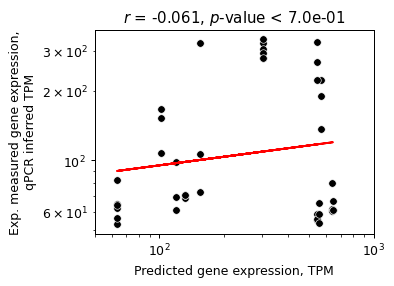

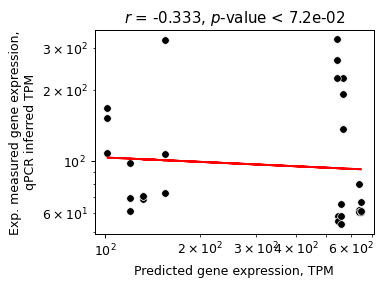

In [19]:
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))

data2 = df_plot
y = data2.ytpm_cr.values
x = data2.ytpm.values
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=data2.query('~construct.isin(["RPL3","POP6"])'),
               x='ytpm',y='ytpm_cr',
               color='k') #,label='generated')
sns.scatterplot(data=data2.query('construct.isin(["RPL3"])'),
               x='ytpm',y='ytpm_cr',
               color='k') #,label='ctrl_RPL3')
sns.scatterplot(data=data2.query('construct.isin(["POP6"])'),
               x='ytpm',y='ytpm_cr',
               color='k') #,label='ctrl_POP6')

plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted gene expression, TPM')
plt.ylabel('Exp. measured gene expression,\nqPCR inferred TPM')
plt.title('$r$ = '+str("%.3f" % corrf(x,y)[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(corrf(x,y)[1])))
plt.xlim([50,1000])
plt.show()

plt.figure(figsize=(4,3))
data2 = df_plot.query('~construct.isin(["RPL3","POP6"])')

y = data2.ytpm_cr.values
x = data2.ytpm.values
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)

sns.scatterplot(data=data2.query('~construct.isin(["RPL3","POP6"])'),
               x='ytpm',y='ytpm_cr',
               color='k')

plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted gene expression, TPM')
plt.ylabel('Exp. measured gene expression,\nqPCR inferred TPM')
plt.title('$r$ = '+str("%.3f" % corrf(x,y)[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(corrf(x,y)[1])))
plt.show()


In [20]:
# s table
df_plot = data.merge(df_exp2,left_on='construct',right_on='index',how='left')
df_plot.at[df_plot.construct=='RPL3','plotcol2'] = 'RPL3'
df_plot.at[df_plot.construct=='RPL3','bin'] = 'RPL3'
df_plot.at[df_plot.construct=='RPL3','perc'] = 0
df_plot.at[df_plot.construct=='RPL3','window'] = 0
df_plot.at[df_plot.construct=='RPL3','ytpm'] = 303.201111
df_plot.at[df_plot.construct=='POP6','plotcol2'] = 'POP6'
df_plot.at[df_plot.construct=='POP6','bin'] = 'POP6'
df_plot.at[df_plot.construct=='POP6','perc'] = 0
df_plot.at[df_plot.construct=='POP6','window'] = 0
df_plot.at[df_plot.construct=='POP6','ytpm'] = 63.628151
df_plot.groupby(['construct','bin','window','perc','batch','ytpm','2pddct_avg'])['ytpm_cr'].mean().reset_index().sort_values(by='bin')


,construct,bin,window,perc,batch,ytpm,2pddct_avg,ytpm_cr
10,POP6,POP6,0.0,0.00,1,63.628151,18.633999,63.628090
11,POP6,POP6,0.0,0.00,2,63.628151,91.293191,63.628090
12,RPL3,RPL3,0.0,0.00,1,303.201111,1925.341112,303.201363
13,RPL3,RPL3,0.0,0.00,2,303.201111,1509.687244,303.201363
1,3059399,h,10.0,0.05,2,555.576350,65.112929,59.206123
2,3080857,h,10.0,0.05,2,645.090150,86.430866,62.806821
3,3438152,h,10.0,0.10,2,635.449160,113.701395,67.412938
4,3480767,h,10.0,0.10,2,544.092650,48.966039,56.478839
8,8207535,h,400.0,0.10,1,541.378200,1689.548655,273.574594
9,8248101,h,400.0,0.10,1,564.844360,975.182440,183.816156
